<img src='images/rnn/simplernn.png'>

<img src="images/rnn/lstm.png">

<img src="images/rnn/gru.png">

In [1]:
#출처: 

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

    #시리즈: 진폭이 동일하고 진동수와 위상이 랜덤한 두 개의 사인 곡선을 더한 후 잡음을 더한 것.

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

X_train.shape, y_train.shape
#X_train: 7000개의 시계열. t=1~50까지 데이터.
#y_train: 7000개의 숫자. X_train과 이어지는 값.

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


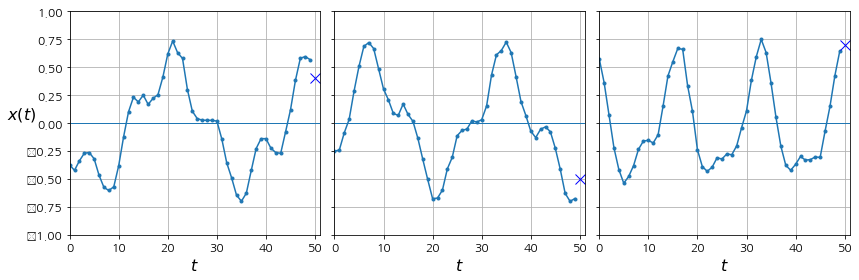

In [3]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


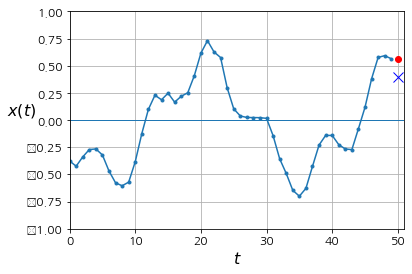

In [4]:
# 베이스라인 모델: naive forecasting = 마지막 값과 같은 값을 예측 하는 것. 

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

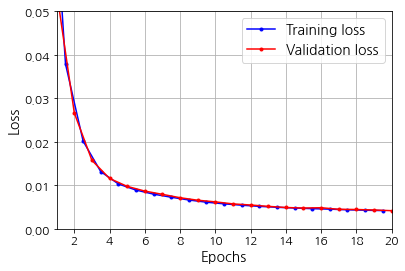

C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


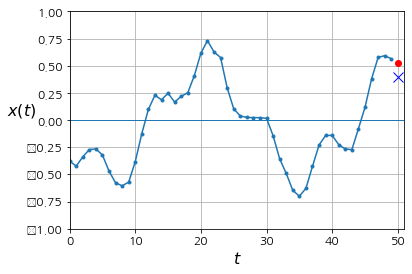

In [5]:
# FC네트워크 사용

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Epoch 1/5
274/274 [==============================] - 16s 55ms/step - loss: 0.0855 - val_loss: 0.0406
Epoch 2/5
274/274 [==============================] - 15s 54ms/step - loss: 0.0307 - val_loss: 0.0243
Epoch 3/5
274/274 [==============================] - 15s 54ms/step - loss: 0.0208 - val_loss: 0.0180
Epoch 4/5
274/274 [==============================] - 14s 51ms/step - loss: 0.0163 - val_loss: 0.0147
Epoch 5/5
274/274 [==============================] - 15s 54ms/step - loss: 0.0138 - val_loss: 0.0129


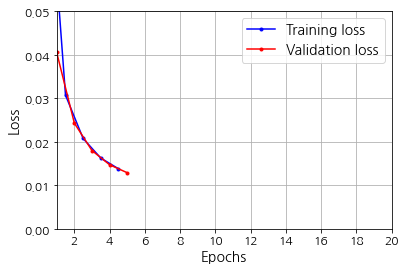

C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


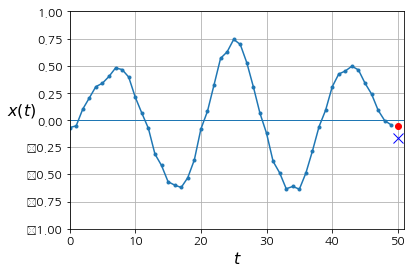

In [12]:

# 단순한 RNN: keras.layers.SimpleRNN
# 하이퍼볼릭 탄젠트 활성화 함수

with tf.device("/device:GPU:0"):

    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential([
        keras.layers.SimpleRNN(1, input_shape=[None, 1])
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss="mse", optimizer=optimizer)

    n_steps = 50
    times = 5
    series = generate_time_series(10000*times, n_steps + 1)
    X_train, y_train = series[:7000*times, :n_steps], series[:7000*times, -1]
    X_valid, y_valid = series[7000*times:9000*times, :n_steps], series[7000*times:9000*times, -1]
    X_test, y_test = series[9000*times:, :n_steps], series[9000*times:, -1]

    history = model.fit(X_train, y_train, epochs=5, batch_size=128,
                            validation_data=(X_valid, y_valid))

    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()

    y_pred = model.predict(X_valid)
    plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
    plt.show() #gpu 30초

Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 0.0469 - val_loss: 0.0097
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0035 - val_lo

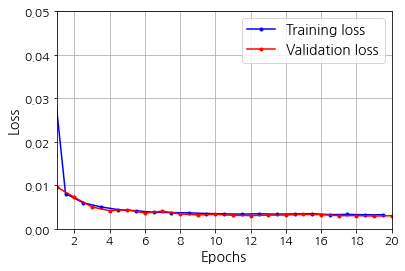

C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


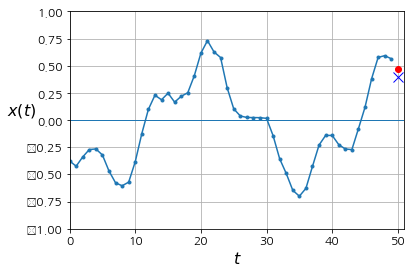

In [28]:
# 깊은 RNN
# units은 output의 차원이며, 
# return_sequences는 RNN에서 마지막 output 시퀀스에서만 결과를 출력할 지, 아니면 모든 시퀀스에서 결과를 출력할 지에 대한 여부를 나타냅니다.
# whole_sequence_output, final_state = tf.keras.layers.SimpleRNN(4)(inputs)
# 인풋: (32,10,8)짜리 시퀀스 데이터 = 32개의 t=1~10짜리 8차원 데이터
# 아웃풋: whole_sequence_output , fianl_state = (32,10,4)짜리 시퀀스 데이터,  (32,4)짜리 시퀀스 데이터
# final_state은 whole_sequence_output의 마지막 번째 데이터와 일치한다. 

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [32]:
# simple_rnn = tf.keras.layers.SimpleRNN(4, return_sequences=True, return_state=True)
# 인풋: (32,10,8)짜리 시퀀스 데이터 = 32개의 t=1~10짜리 8차원 데이터
# 아웃풋: whole_sequence_output , fianl_state = (32,10,4)짜리 시퀀스 데이터,  (32,4)짜리 시퀀스 데이터
# units은 output의 차원이며, 
# return_sequences는 RNN에서 마지막 output 시퀀스에서만 결과를 출력할 지, 아니면 모든 시퀀스에서 결과를 출력할 지에 대한 여부를 나타냅니다.

# 인풋 데이터 준비
inputs = np.random.random([32, 10, 8]).astype(np.float32)

# return_sequences=False
simple_rnn = tf.keras.layers.SimpleRNN(4)
output = simple_rnn(inputs)  # The output has shape `[32, 4]`.
print('==return_sequences=False==')
print('input:',inputs.shape)
print('output:',output.shape)

# return_sequences=False
simple_rnn = tf.keras.layers.SimpleRNN(4, return_sequences=True)
output = simple_rnn(inputs)  # The output has shape `[32, 4]`.
print('==return_sequences=True==')
print('input:',inputs.shape)
print('output:',output.shape)

# return_sequences=False
simple_rnn = tf.keras.layers.SimpleRNN(4, return_sequences=True, return_state=True)
output1,output2 = simple_rnn(inputs)  # The output has shape `[32, 4]`.
print('==return_sequences=True==')
print('input:',inputs.shape)
print('output:',output1.shape,output2.shape)

==return_sequences=False==
input: (32, 10, 8)
output: (32, 4)
==return_sequences=True==
input: (32, 10, 8)
output: (32, 10, 4)
==return_sequences=True==
input: (32, 10, 8)
output: (32, 10, 4) (32, 4)


In [33]:
#Deep RNN 비교

#1
#마지막 층에서 t=1~10짜리 1차원짜리 시퀀스 데이터가 나오는데, 이중에서 t=10마지막 데이터를 산출하게됨

model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

#2
#마지막 층에서 시퀀스 데이터가 산출되지 않고, Dense한 데이터가 산출됨
#2번째 히든 레이어에서 t=1~10짜리 20차원 시퀀스 데이터 중 t=10 마지막 데이터를 산출하게 됨.
#이때의 20차원 짜리 데이터를 Dense레이어에 의해 1차원으로 줄여줌 (활성화 함수 변경 가능)
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])


#2가 더 빠르게 수렴하고 성능이 더 좋음. 


In [38]:
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1])(X_train)

<tf.Tensor: shape=(7000, 50, 20), dtype=float32, numpy=
array([[[ 2.21500412e-01, -2.33092293e-01, -9.03715417e-02, ...,
          1.02773696e-01,  1.84010133e-01, -8.07099883e-03],
        [ 6.25175312e-02,  7.18414318e-03, -1.61037892e-01, ...,
          1.69575602e-01,  1.47541821e-01, -2.15299815e-01],
        [ 1.18129618e-01, -1.52584583e-01, -2.57028908e-01, ...,
          2.38285109e-01,  2.56503433e-01, -2.83748824e-02],
        ...,
        [-6.90129399e-02,  1.10105693e-01,  2.43280865e-02, ...,
          1.49704739e-01,  6.85221404e-02,  1.66279852e-01],
        [-3.21039930e-03,  1.83955878e-01,  1.06411010e-01, ...,
          1.59037724e-01,  7.18405843e-02,  8.34411606e-02],
        [-5.33372834e-02,  1.25618175e-01, -2.76018269e-02, ...,
          1.96098894e-01,  1.50957108e-01,  4.64477278e-02]],

       [[ 1.29368246e-01, -1.36304095e-01, -5.22946604e-02, ...,
          5.95031865e-02,  1.07098557e-01, -4.66196518e-03],
        [ 5.26410565e-02, -1.29728615e-02, -1.0

Epoch 1/10
28/28 [==============================] - 7s 203ms/step - loss: 0.1516 - val_loss: 0.0888
Epoch 2/10
28/28 [==============================] - 6s 200ms/step - loss: 0.0630 - val_loss: 0.0427
Epoch 3/10
28/28 [==============================] - 6s 196ms/step - loss: 0.0373 - val_loss: 0.0323
Epoch 4/10
28/28 [==============================] - 5s 185ms/step - loss: 0.0314 - val_loss: 0.0288
Epoch 5/10
28/28 [==============================] - 5s 192ms/step - loss: 0.0283 - val_loss: 0.0261
Epoch 6/10
28/28 [==============================] - 5s 180ms/step - loss: 0.0264 - val_loss: 0.0247
Epoch 7/10
28/28 [==============================] - 5s 196ms/step - loss: 0.0250 - val_loss: 0.0235
Epoch 8/10
28/28 [==============================] - 5s 182ms/step - loss: 0.0241 - val_loss: 0.0226
Epoch 9/10
28/28 [==============================] - 5s 180ms/step - loss: 0.0236 - val_loss: 0.0225
Epoch 10/10
28/28 [==============================] - 5s 192ms/step - loss: 0.0228 - val_loss: 0.0213

C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


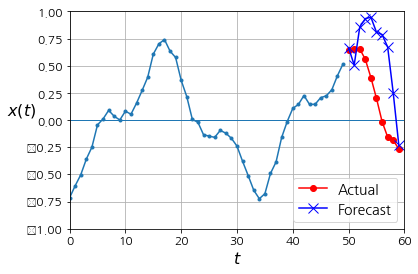

In [18]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


#새로운 데이터
#x와 y를 나누는 방법
#series: (데이터개수, t, 디맨션)
#x데이터: (데이터개수, 1~50, 디맨션1)
#y데이터: (데이터개수, 51~60, 디맨션1)

np.random.seed(42)
n_steps = 80
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

np.random.seed(42)
tf.random.set_seed(42)

#모델구조
#인풋: (n, 1~50, 1)
#1층RNN: (n, 1~50, 20차원)
#2층RNN: (n, 마지막(50번째), 20차원)
#3층Dense: (n, 51~60)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
with tf.device("/device:GPU:0"):

    history = model.fit(X_train, Y_train, epochs=10, batch_size=256,
                        validation_data=(X_valid, Y_valid))

np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()#c:20초 #g:54

In [22]:
#lstm

#input: (n, 1~50, 20d)
#lstm1: (n, 1~50, 20d)
#lstm2: (n, 1~50, 20d)
#timedistributed(n, 1~50, 10d)
#각각의 t에 대해 dense layer를 수행하여 20차원 -> 10차원으로 만든다.

np.random.seed(42)
with tf.device("/device:GPU:0"):
    n_steps = 50
    series = generate_time_series(10000, n_steps + 10)
    X_train = series[:7000, :n_steps]
    X_valid = series[7000:9000, :n_steps]
    X_test = series[9000:, :n_steps]
    Y = np.empty((10000, n_steps, 10))
    for step_ahead in range(1, 10 + 1):
        Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    Y_train = Y[:7000]
    Y_valid = Y[7000:9000]
    Y_test = Y[9000:]

    tf.random.set_seed(42)


    model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])
    def last_time_step_mse(Y_true, Y_pred):
        return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

    model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    history = model.fit(X_train, Y_train, epochs=10, batch_size=256,
                        validation_data=(X_valid, Y_valid))

Epoch 1/10
28/28 [==============================] - 3s 34ms/step - loss: 0.1272 - last_time_step_mse: 0.1243 - val_loss: 0.1040 - val_last_time_step_mse: 0.0973
Epoch 2/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0913 - last_time_step_mse: 0.0794 - val_loss: 0.0806 - val_last_time_step_mse: 0.0666
Epoch 3/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0761 - last_time_step_mse: 0.0610 - val_loss: 0.0698 - val_last_time_step_mse: 0.0529
Epoch 4/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0665 - last_time_step_mse: 0.0494 - val_loss: 0.0624 - val_last_time_step_mse: 0.0451
Epoch 5/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0608 - last_time_step_mse: 0.0431 - val_loss: 0.0589 - val_last_time_step_mse: 0.0415
Epoch 6/10
28/28 [==============================] - 0s 9ms/step - loss: 0.0573 - last_time_step_mse: 0.0389 - val_loss: 0.0557 - val_last_time_step_mse: 0.0362
Epoch 7/10
28/28 [=====================

In [24]:
#GRU

np.random.seed(42)
tf.random.set_seed(42)
with tf.device("/device:CPU:0"):
    model = keras.models.Sequential([
        keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    history = model.fit(X_train, Y_train, epochs=20,
                        validation_data=(X_valid, Y_valid))#32

Epoch 1/20
219/219 [==============================] - 7s 23ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 4s 21ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==